## JAX Setup
Code adapted from [JAX examples](https://github.com/google/jax/blob/master/examples/mnist_classifier.py).

In [1]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

import time
import itertools

import numpy.random as npr

import jax.numpy as np
from jax.config import config
from jax import jit, grad, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, LogSoftmax, BatchNorm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


# used for tensorflow datasets
# import tensorflow as tf
# tf.enable_eager_execution()

2022-03-22 23:41:40.769286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/home/adamo/miniconda3/envs/2541/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MNIST Setup

In [2]:
rng = random.PRNGKey(0)

step_size = 0.001
num_epochs = 3
batch_size = 128
momentum_mass = 0.9

NUM_CLASSES = 10

2022-03-22 23:41:41.992533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 23:41:41.992597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-22 23:41:41.992648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-22 23:41:41.992698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-03-22 23:41:41.992748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


Text(0.5, 1.0, '[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]')

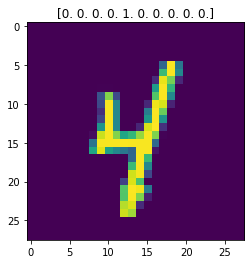

In [3]:
#load mnist
train_ds = tfds.load("mnist", split=tfds.Split.TRAIN, batch_size=-1)
numpy_ds = tfds.as_numpy(train_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
numpy_images.shape, numpy_labels.shape
train_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(np.float32)/255.0
train_labels = np.eye(NUM_CLASSES)[numpy_labels]


test_ds = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
numpy_ds = tfds.as_numpy(test_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
numpy_images.shape, numpy_labels.shape
test_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(np.float32)/255.0
test_labels = np.eye(NUM_CLASSES)[numpy_labels]
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

plt.imshow(train_images[0].reshape(28,28))
plt.title(str(train_labels[0]))

In [4]:
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [5]:
def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

batches = data_stream()

In [6]:
init_random_params, predict = stax.serial(
    Dense(1024), Relu,
    Dense(1024), Relu,
    Dense(10), LogSoftmax)

In [7]:
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -np.mean(preds * targets)

def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

In [8]:
import jax.tree_util as tu

In [9]:
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

_, init_params = init_random_params(rng, (-1, 28 * 28))

# scale params to make spectrum more interesting
init_params = tu.tree_map(lambda x: x*10, init_params)

opt_state = opt_init(init_params)
itercount = itertools.count()

## Train MNIST Regularly

In [10]:
print("\nStarting training...")
for epoch in range(num_epochs):
  start_time = time.time()
  for _ in range(num_batches):
    opt_state = update(next(itercount), opt_state, next(batches))
  epoch_time = time.time() - start_time

  params = get_params(opt_state)
  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))


Starting training...
Epoch 0 in 4.15 sec
Training set accuracy 0.8506667017936707
Test set accuracy 0.8519999980926514
Epoch 1 in 3.34 sec
Training set accuracy 0.8862833380699158
Test set accuracy 0.8833000063896179
Epoch 2 in 3.71 sec
Training set accuracy 0.90420001745224
Test set accuracy 0.8935999870300293


## MNIST Hessian Spectrum

In [28]:
import matplotlib.pyplot as plt

import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

In [29]:
# make a generator that yields 1/10th an epoch
batches_list = [next(batches) for i in range(num_batches // 10)]
def batches_fn():
  for b in batches_list:
    yield b

# print(batch_size,num_batches)
# print(len(batches_list))
# print([(b[0].shape,b[1].shape) for b in batches_list])

In [30]:
# Hessian-vector product function + Lanczos 
order = 90
hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [31]:
print("num_params: {}".format(num_params))
start = time.time()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.time()
print("hvp compile time: {}".format(end-start))
start = time.time()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.time()
print("hvp compute time: {}".format(end-start))

num_params: 1863690
hvp compile time: 1.4765772819519043
hvp compute time: 0.8874094486236572


In [32]:
rng, split = random.split(rng)
start = time.time()
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.time()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

Lanczos time: 118.25918483734131


In [33]:
def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.legend()

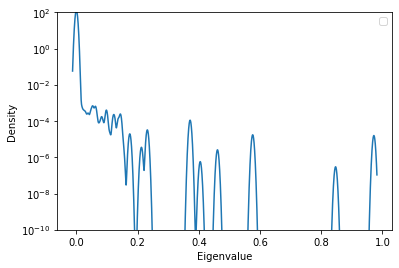

In [34]:
plot(grids, density) # 30 epochs no BN